In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import ggplot 
from sklearn.ensemble import RandomForestClassifier

# 1. Load and Check Data

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [3]:
# Preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Get info of data
train_df.info()
print '-------------------------------------'
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null ob

In [14]:
# Missing values
print train_df.isnull().any()
print '-------------------'
print test_df.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool
-------------------
PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool


# 2. Feature Engineering

This code always shows error but I didn't find why. The RareTitle seems don't even exist in the full.Title column. 
So I want to see what the real values are in the column, and the reason is --- 
THERE IS A WHITE SPACE IN FRONT OF EACH VALUE
To solve this, need to **`strip`** each value in the **`title`** Series

In [15]:
# Drop unnessary feature
# train_df = train_df.drop('PassengerId', 1)
train_df.head()
train_df.Ticket.describe()
train_df.Cabin.isnull().sum()
pd.crosstab(train_df.Survived, train_df.Cabin)

Cabin,A10,A14,A16,A19,A20,A23,A24,A26,A31,A32,...,E8,F E69,F G63,F G73,F2,F33,F38,F4,G6,T
Survived,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,1,0,0,1,0,0,1,...,0,0,1,2,1,0,1,0,2,1
1,0,0,1,0,1,1,0,1,1,0,...,2,1,0,0,2,3,0,2,2,0


## Name 

I dropped the Name feature the first time, but from the answer [First Voted on Kaggle](https://www.kaggle.io/svf/789314/d34daa0437817eb4a1b486709b1cf8b0/__results__.html#load-and-check-data), there is useful information in a person's name, which is the **Title**. So I make the **Title** feature in my analysis too.

In [16]:
title = train_df.Name.str.extract('(\,)(\s\w+\s*\w*)(\.)')[1].str.strip()
train_df['Title'] = title
pd.crosstab(train_df.Sex, train_df.Title)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


Title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,
female,0,0,0,1,0,1,0,0,182,2,1,0,125,1,0,0,1
male,1,2,1,6,1,0,2,40,0,0,0,517,0,0,6,1,0


In [96]:
pd.isnull(train_df.Title).sum()

0




#### What do those rare prefix mean? Here is a table:    

|Title|Description|
|----|----|
| Capt  | Captain   |
| Col | Colonel  |   
|  Dr | Doctor  |  
|Ms|Single or Married Women|
|Mme|Mrs|
|Mlle|Miss|
|Ms|Don't show marital status, conclude as rare|

In [17]:
RareTitle = ['Capt', 'Col', 'Don', 'Dona', 'Jonkheer', 'Lady', 'Major', 'Dr',
             'Ms', 'Rev', 'Sir', 'the Countess']

In [18]:
train_df.replace({'Title':{'Mlle': 'Miss', 'Mme': 'Mrs'}}, inplace=True)
train_df.replace(RareTitle, 'RareTitle', inplace=True)
train_df.Title.unique()
pd.crosstab(train_df.Sex, train_df.Title)

Title,Master,Miss,Mr,Mrs,RareTitle
Sex,,,,,
female,0,184,0,126,4
male,40,0,517,0,20


Do the samething to test_df

In [19]:
test_title = test_df.Name.str.extract('(\,)(\s\w+\s*\w*)(\.)')[1].str.strip()
test_df['Title'] = test_title
pd.isnull(test_df.Title).sum() 
test_df.replace({'Title':{'Mlle': 'Miss', 'Mme': 'Mrs'}}, inplace=True)
test_df.replace(RareTitle, 'RareTitle', inplace=True)
pd.crosstab(test_df.Sex, test_df.Title)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


Title,Master,Miss,Mr,Mrs,RareTitle
Sex,,,,,
female,0,78,0,72,2
male,21,0,240,0,5


## Age

Age can be grouped as a categorical feature. So here I will add a new column of categorical age features

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


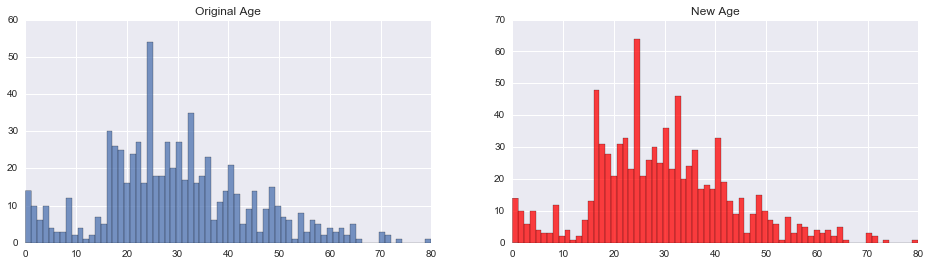

In [20]:
# Average, std and count of nan values in train_df.Age
mean_train = train_df.Age.mean()
std_train = train_df.Age.std()
count_of_nan_age_train = pd.isnull(train_df.Age).sum()

# Average, std and count of nan values in test_df.Age
mean_test = test_df.Age.mean()
std_test = test_df.Age.std()
count_of_nan_age_test = pd.isnull(test_df.Age).sum()

# Generate random numbers b/w (mean-std) and (mean+std)
rand_train = np.random.randint((mean_train-std_train), (mean_train+std_train), count_of_nan_age_train)
rand_test = np.random.randint((mean_test-std_test), (mean_test+std_test), count_of_nan_age_test)

# Plot
plt.figure(1, (16,4))
# Plot original Age in train_df
plt.subplot(121)
plt.hist(train_df.Age.dropna().astype(int), bins=70, alpha=0.75)
plt.title('Original Age')

# Fill NA 
train_df.Age[pd.isnull(train_df.Age)] = rand_train
test_df.Age[pd.isnull(test_df.Age)] = rand_test

# Convert Age from float to int
train_df.Age = train_df.Age.astype(int)
test_df.Age = test_df.Age.astype(int)

# Plot new train_df.Age
plt.subplot(122)
plt.hist(train_df.Age.dropna().astype(int), color = 'red',bins=70, alpha=0.75)
plt.title('New Age')

plt.show()

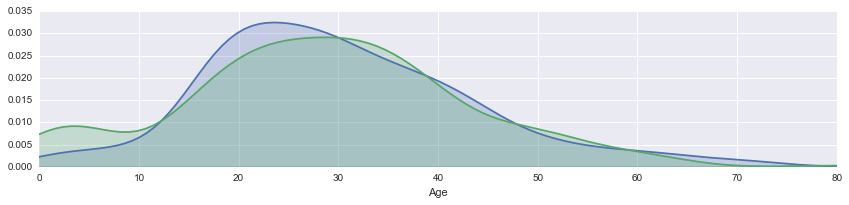

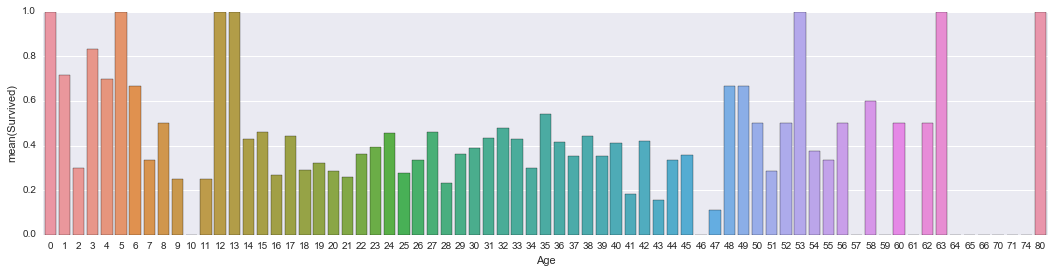

In [43]:
# Density plot of Age and color in Surveived
facet = sns.FacetGrid(train_df, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train_df.Age.max()))
# facet.add_legend()

f, ax = plt.subplots(figsize=(18,4))
average_age = train_df[['Age', 'Survived']].groupby(['Age'], as_index=False).mean()
sns.barplot(x='Age', y='Survived', data = average_age)
plt.show()

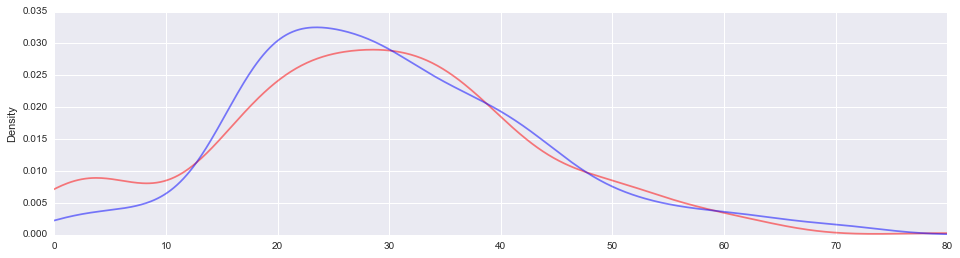

In [40]:
plt.figure(figsize=(16,4))
train_df.Age[train_df.Survived==1].plot('kde', color='r', alpha=0.5, xlim=(0, max(train_df.Age[train_df.Survived==1])))
train_df.Age[train_df.Survived==0].plot('kde', color='b', alpha=0.5)

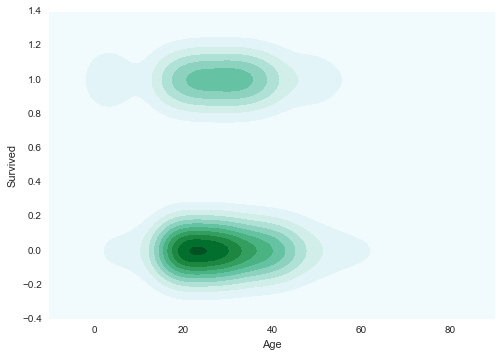

In [49]:
sns.kdeplot(train_df.Age, train_df.Survived, shade=True, legend=True, shade_lowest=True)

In [56]:
train_df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

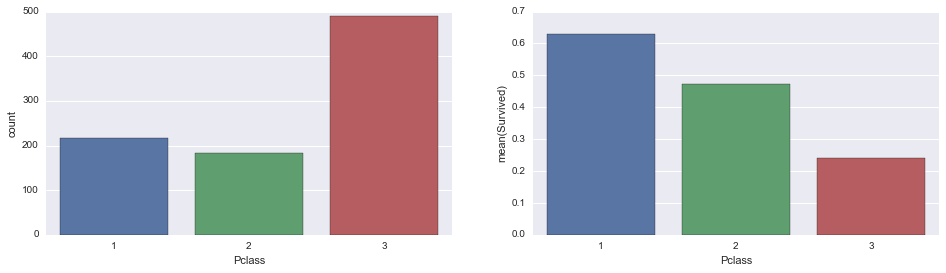

In [102]:
pcalss_mean = train_df[['Pclass', 'Survived']].groupby(('Pclass'), as_index=False).mean()
f, (a1, a2) = plt.subplots(1,2, figsize=(16, 4))
sns.countplot(x='Pclass', data=train_df, ax=a1)
sns.barplot(x='Pclass', y='Survived',data=pcalss_mean, ax=a2)

In [103]:
train_df[pd.isnull(train_df.Embarked)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80.0,B28,NaN,Mrs


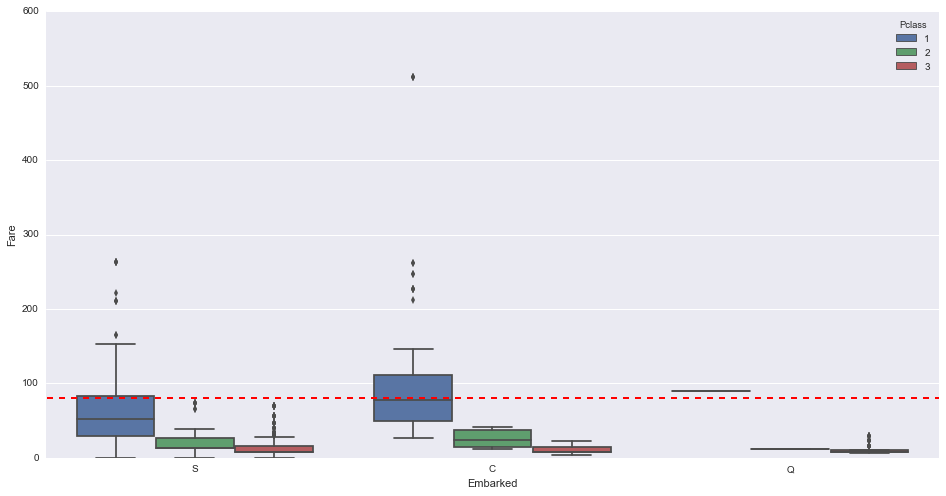

In [104]:
# See hwo Fare, Pclass and Emabrked are distributed. The two missing values in Embarked have fare of 80
# The red dotted line is fare=80
plt.figure(figsize=(16,8))
plt.plot([-1,3],[80, 80], '--', lw=2, c='red')
sns.boxplot(x='Embarked', y='Fare', hue='Pclass', data=train_df)

In [105]:
# The two people are in class 1, and 80 is close to the mean of Embark C. So add C to their Embarked value
train_df.Embarked[pd.isnull(train_df.Embarked)] = 'C'
train_df.iloc[[61, 829],:]

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80.0,B28,C,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80.0,B28,C,Mrs


In [120]:
# There is one missing value in Fare in test_df 
test_df[pd.isnull(test_df.Fare)]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
152,1044,3,"Storey, Mr. Thomas",male,60,0,0,3701,NaN,NaN,S,Mr


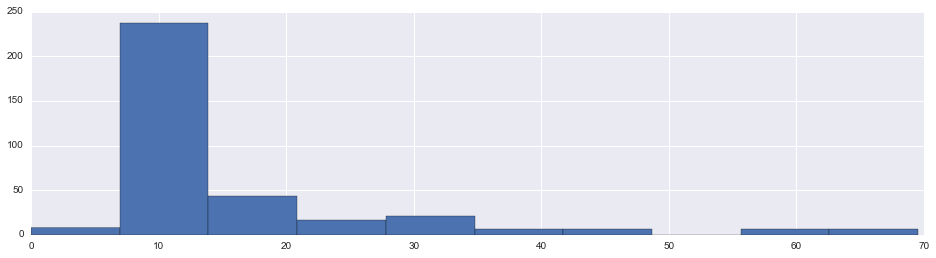

In [132]:
# A 3 class passenger Embarked from S. Visualize this group pf people
plt.figure(figsize=(16,4))
plt.hist(train_df.Fare[(train_df.Pclass==3) & (train_df.Embarked=='S')])
plt.show()

In [137]:
# From the graph, most Fares fall into 10. Calculate the median and put it into the missing value
fare_test = train_df.Fare[(train_df.Pclass==3) & (train_df.Embarked=='S')].median()
test_df.Fare[pd.isnull(test_df.Fare)] = fare_test
test_df.iloc[[152]]

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
152,1044,3,"Storey, Mr. Thomas",male,60,0,0,3701,8.05,NaN,S,Mr


## 2.3 Ticket

In [295]:
# There is no missing calu
pd.isnull(train_df.Ticket).sum()

0

## 2.4 Embarcked

In [277]:
train_df[pd.isnull(train_df.Embarked)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80.0,B28,NaN,Mrs


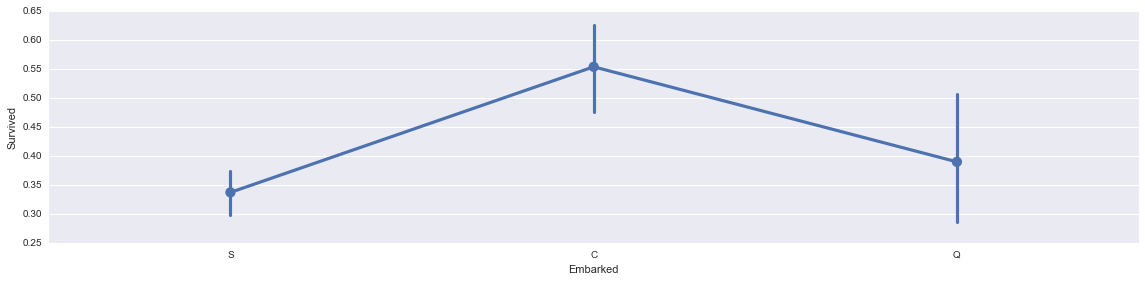

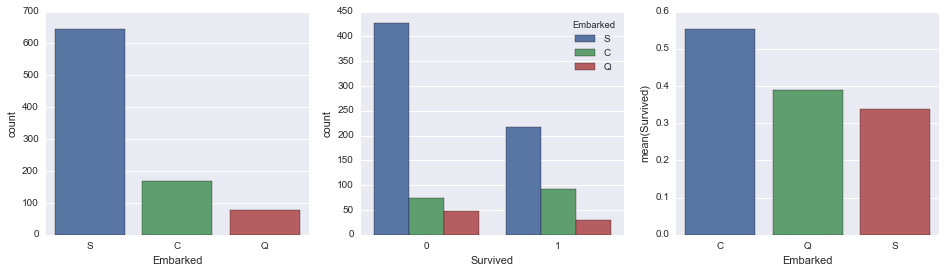

In [325]:
sns.factorplot(x='Embarked', y='Survived', data=train_df, aspect=4)
f, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize = (16, 4))
sns.countplot(x='Embarked', data=train_df, ax=ax1)
sns.countplot(x='Survived', hue="Embarked", data=train_df, ax=ax2)

# Emabarked percentage of survival
embarked_perc = train_df[['Embarked', 'Survived']].groupby(('Embarked'), as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embarked_perc, ax=ax3)

In [352]:
train_df[['Pclass', 'Embarked']].groupby(['Embarked']).count()
pd.crosstab(train_df.Embarked, [train_df.Pclass, train_df.Survived])

Pclass     1       2        3    
Survived   0   1   0   1    0   1
Embarked                         
C         26  59   8   9   41  25
Q          1   1   1   2   45  27
S         53  74  88  76  286  67

## 2.5 SibSp and Parch

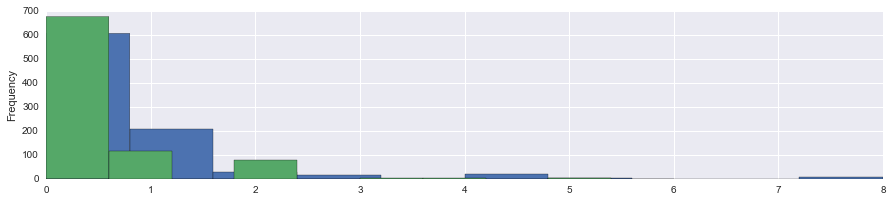

In [145]:
train_df.SibSp.plot(kind='hist', figsize=(15,3))
train_df.Parch.plot(kind='hist', figsize=(15,3))

In [160]:
family_train = train_df.SibSp + train_df.Parch
train_df['FamilySize'] = family_train
family_test = test_df.SibSp + test_df.Parch
test_df['FamilySize'] = family_test
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,NaN,Q,Mr,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,NaN,S,Mrs,1
2,894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,NaN,Q,Mr,0
3,895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,NaN,S,Mr,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,NaN,S,Mrs,2


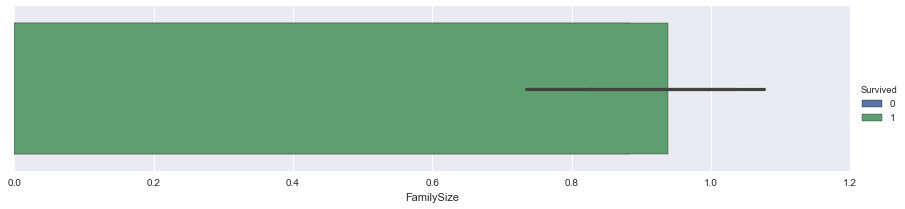

In [170]:
facet = sns.FacetGrid(train_df, hue='Survived', aspect=4)
facet.map(sns.barplot, 'FamilySize')
# facet.set(xlim=(0, train_df.FamilySize.max()))
facet.add_legend()

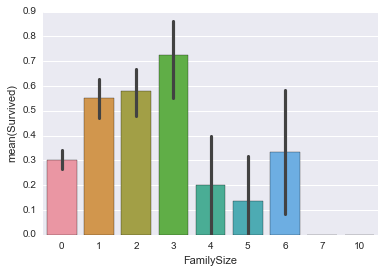

In [198]:
sns.barplot(x='FamilySize', y ='Survived', data=train_df)

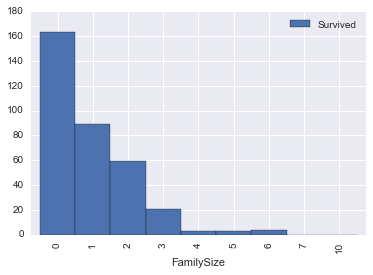

In [196]:
f = train_df[['FamilySize', 'Survived']].groupby(['FamilySize']).sum()
f.plot(kind = 'bar', width = 1)

In [191]:
train_df[['FamilySize', 'Survived']].groupby(['FamilySize']).sum()

,Survived
FamilySize,
0,163
1,89
2,59
3,21
4,3
5,3
6,4
7,0
10,0


# 3. Prediction

In [9]:
train_df = train_df.drop(['PassengerId','Name','Ticket'], 1)
test_df = test_df.drop(['PassengerId','Name', 'Ticket'], 1)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Prefix
0,0,3,male,22.0,1,0,7.2500,NaN,S,Mr
1,1,1,female,38.0,1,0,71.2833,C85,C,Mrs
2,1,3,female,26.0,0,0,7.9250,NaN,S,Miss
3,1,1,female,35.0,1,0,53.1000,C123,S,Mrs
4,0,3,male,35.0,0,0,8.0500,NaN,S,Mr


In [10]:
train_df.groupby(['Pclass','Survived']).count()

Sex  Age  SibSp  Parch  Fare  Cabin  Embarked  Prefix
Pclass Survived                                                       
1      0          80   64     80     80    80     59        80      80
       1         136  122    136    136   136    117       134     136
2      0          97   90     97     97    97      3        97      97
       1          87   83     87     87    87     13        87      87
3      0         372  270    372    372   372      6       372     372
       1         119   85    119    119   119      6       119     119

In [11]:
pd.pivot_table(train_df, values='Survived', index=['Sex', 'Pclass'], columns='Age', aggfunc=len)

Age            0.42   0.67   0.75   0.83   0.92   1.00   2.00   3.00   4.00   \
Sex    Pclass                                                                  
female 1         NaN    NaN    NaN    NaN    NaN    NaN    1.0    NaN    NaN   
       2         NaN    NaN    NaN    NaN    NaN    NaN    1.0    1.0    2.0   
       3         NaN    NaN    2.0    NaN    NaN    2.0    4.0    1.0    3.0   
male   1         NaN    NaN    NaN    NaN    1.0    NaN    NaN    NaN    1.0   
       2         NaN    1.0    NaN    2.0    NaN    2.0    1.0    2.0    NaN   
       3         1.0    NaN    NaN    NaN    NaN    3.0    3.0    2.0    4.0   

Age            5.00   ...    62.00  63.00  64.00  65.00  66.00  70.00  70.50  \
Sex    Pclass         ...                                                      
female 1         NaN  ...      1.0    1.0    NaN    NaN    NaN    NaN    NaN   
       2         1.0  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
       3         3.0  ...      NaN    1.0    NaN    NaN    NaN    NaN    NaN   
male   1         NaN  ...      2.0    NaN    2.0    2.0    NaN    1.0    NaN   
       2         NaN  ...      1.0    NaN    NaN    NaN    1.0    1.0    NaN   
       3         NaN  ...      NaN    NaN    NaN    1.0    NaN    NaN    1.0   

Age            71.00  74.00  80.00  
Sex    Pclass                       
female 1         NaN    NaN    NaN  
       2         NaN    NaN    NaN  
       3         NaN    NaN    NaN  
male   1         2.0    NaN    1.0  
       2         NaN    NaN    NaN  
       3         NaN    1.0    NaN  

[6 rows x 88 columns]

In [12]:
train_df.describe()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
train_df.cov()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,0.236772,-0.137703,-0.551296,-0.018954,0.032017,6.221787
Pclass,-0.137703,0.699015,-4.496004,0.076599,0.012429,-22.830196
Age,-0.551296,-4.496004,211.019125,-4.163334,-2.344191,73.849030
SibSp,-0.018954,0.076599,-4.163334,1.216043,0.368739,8.748734
Parch,0.032017,0.012429,-2.344191,0.368739,0.649728,8.661052
Fare,6.221787,-22.830196,73.849030,8.748734,8.661052,2469.436846


In [14]:
train_df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


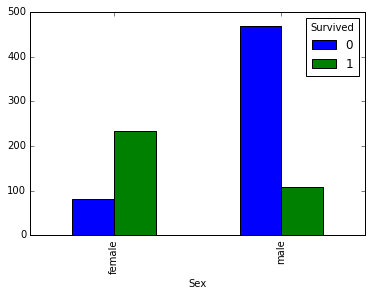

In [53]:
c = pd.crosstab(train_df.Sex, train_df.Survived)
c.plot(kind='bar')

In [102]:
pd.isnull(train_df[['Embarked']]).any(1).nonzero()

(array([ 61, 829]),)

In [281]:
train_df.groupby(['Embarked']).count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Prefix
Embarked,,,,,,,,,,,,
C,168,168,168,168,168,130,168,168,168,168,69,168
Q,77,77,77,77,77,28,77,77,77,77,4,77
S,644,644,644,644,644,554,644,644,644,644,129,644


In [43]:
pd.isnull(train_df[['Embarked']]).iloc[[,3]]

SyntaxError: invalid syntax (<ipython-input-43-2d622552ecd5>, line 1)

In [41]:
train_df.iloc[[]]

SyntaxError: invalid syntax (<ipython-input-41-55afe836be8a>, line 1)